
# Modeling Expected Goals




In Part I, we took a deep dive into the data and trends of shots based on three key variables; the distance, angle and a categorical variable to identify headed shots. We developed an understanding of the distributions and probabilities associated with shots and goals by representing, transforming and visualizing the data. Here, we use this data to develop a model to predict goals. 

## Classification

First some housekeeping, lets import our data from Part I and our libraries

In [1]:
#make our plots center for jupyster notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Importing Jupyter notebook from xG_model_part1.ipynb


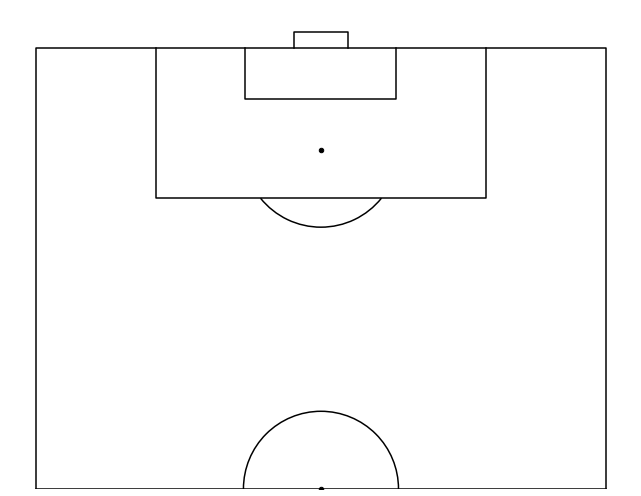

xG_model_part1.ipynb:49: RuntimeWarning: invalid value encountered in arccos
  "source": [


In [2]:
#for extended notes and descriptions, visit part 1
#use nbimporter to extract our shot_matrix function from part 1
import nbimporter
from xG_model_part1 import shot_matrix
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from PlotPitch import draw_pitch
directory = '/Users/Ian/Desktop/IDanalytics/event_data'
jsonfiles = []
for path in os.listdir(directory):
    jsonfiles.append(os.path.join(directory,path))
all_leagues = []
for file in jsonfiles:
    all_leagues.append(shot_matrix(file))
df = pd.concat(all_leagues)

In [3]:
#lets drop nan values and make sure our binary data is numeric for later
df = df.dropna()
#df = df.drop(columns = ['x','y','Center_dis'])
df['header'] = pd.to_numeric(df['header'])
df['Goal'] = pd.to_numeric(df['Goal'])
df

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
213,1,6,57,256992,3799,2500686,0,38.76,6.30,7.0,7.896050,0.755576,43.291300
302,0,17,42,334552,3772,2500686,1,28.56,17.85,8.0,18.660549,0.372069,21.317963
498,1,4,43,26389,3772,2500686,0,29.24,4.20,7.0,6.348039,0.851948,48.813019
577,0,16,21,276920,3772,2500686,0,14.28,16.80,29.0,25.905953,0.184838,10.590449
629,0,27,51,366760,3799,2500686,0,34.68,28.35,1.0,28.358154,0.256637,14.704224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642945,0,28,45,8561,1633,2500098,0,30.60,29.40,5.0,29.595946,0.244517,14.009788
643023,1,14,33,41174,1633,2500098,0,22.44,14.70,17.0,18.700898,0.309646,17.741433
643051,0,12,62,7879,1623,2500098,0,42.16,12.60,12.0,15.011516,0.410444,23.516712
643055,0,8,38,145692,1623,2500098,0,25.84,8.40,12.0,11.710918,0.461143,26.421528



Since our response variable (shot result) is categorical, we must apply classification methods to create a predictive model. To introduce this type of approach, let’s look at an illustrative example. Assume we plot a random selection of shots from our data and classify them based on their result, only taking the distance into account. 

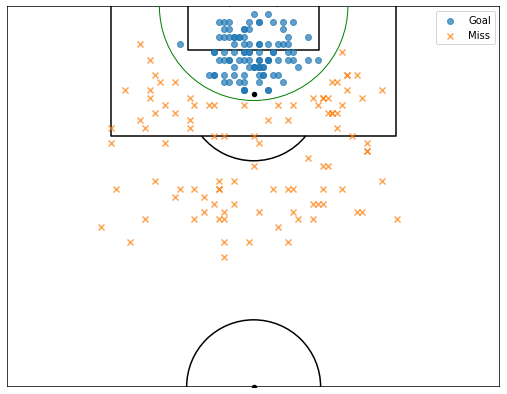

In [4]:
#we are going to plot specific point for a demonstration of what the Heaviside function does
from PlotPitch import draw_pitch
#choose specific goals and misses
idx_goal = np.where((df['Goal']==1) & (df['Distance'] < 12)) 
df_HS_goal = df.iloc[idx_goal]
idx_miss = np.where((df['Goal']==0) & (df['Distance']> 13)) 
df_HS_miss = df.iloc[idx_miss]

#plot them with a bounday line between
prob=np.array(df['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
goals = plt.scatter(data = df_HS_goal.head(100),x='Y', y='X',alpha=.7)
misses = plt.scatter(data = df_HS_miss.head(100),x='Y', y='X',alpha=.7,marker='x')
ax.set_xlim(0,68)
plt.legend((goals,misses),('Goal','Miss'))
ax.set_ylim(52.5,0)
circle = plt.Circle((34,0),13,fill=False, color = 'Green')
ax.add_artist(circle)
plt.axis('off')

plt.show()


Above we can see that there is a clear distinction between the blue and orange clusters. If we assume this is the true nature of the relationship between shots and distance, and we want to predict future shot results based on this data, what model could we adopt?

Since the data is easily separable, we can draw a boundary line between the two clusters.  This line will represent a discriminant function, which we will use to classify each shot outcome as a goal or miss. In the case above, the discriminant function maps out a distance r from the center of the goal. 

This discriminant function, drawn in green, is defined by the equation 𝑦=αx+β, where x is the distance from goal and y is the binary response. Specifically for the data above, y = x -12. We can translate this into a classification model by applying the so-called Heaviside function to our discriminant, which will return a value of 0 or 1 as the response variable is based on the value of y:



$$
\begin{array}{rcl}
  H(y) & \equiv & \left\{\begin{array}{ll}
      0 & \mathrm{if}\ y > 0
      \\
      1 & \mathrm{if}\ y \leq 0
    \end{array}\right..
\end{array}
$$

The Heaviside function is a hard classifier and the simplest classification model, but it requires the data to be cleanly separable.


Text(0.5, 1.0, 'Heaviside Function Classification for Shots')

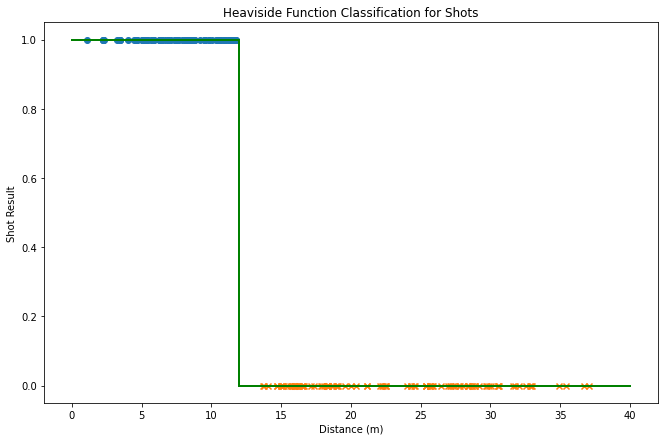

In [5]:
#plot the heaviside function on top of the responses for the seperable data above
df_HS_predictor = np.append(df_HS_goal['Distance'].head(100), df_HS_miss['Distance'].head(100))
df_HS_response = np.append(df_HS_goal['Goal'].head(100), df_HS_miss['Goal'].head(100))

fig, axes = plt.subplots(figsize=(11,7))

goals = plt.scatter(df_HS_goal['Distance'].head(100),df_HS_goal['Goal'].head(100))
misses = plt.scatter(df_HS_miss['Distance'].head(100),df_HS_miss['Goal'].head(100),marker='x')
plt.plot([0,12], [1, 1], 'k-', lw=2,c='green')
plt.plot([12,12], [0, 1], 'k-', lw=2,c='green')
plt.plot([12,40], [0, 0], 'k-', lw=2,c='green')
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.title('Heaviside Function Classification for Shots')


    

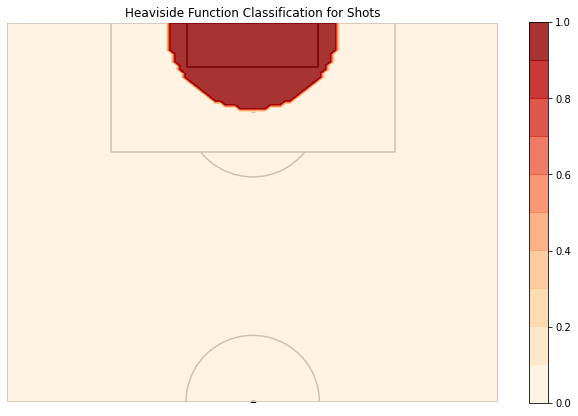

In [6]:
#we are going to create a contour plot to see how the heaviside function classifies onto a pitch
#first we must simulate the data above and we can do that by initializing 
#some numpy arrays what have certain properties
from PlotPitch import draw_pitch 

#heaviside returns 0 if y is negative and 1 otherwise
def heaviside(Y):
    A = np.where(Y<=0, 0, 1)
    return A

#plot contour plot over the pitch from before
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)

x0 = np.linspace(0, 68, 100)
x1 = np.linspace(0,53 , 100)
x11 = np.linspace(53,0 , 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
h_grid = heaviside(144-(x0_grid-34)**2-(x1_grid-53)**2)
plt.contourf(x0, x11, h_grid,cmap='OrRd',alpha=.8,levels=10)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Heaviside Function Classification for Shots')

plt.axis('off')
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()


In reality, the data describing shots is not cleanly separable, making goals difficult to predict with any kind of certainty.  Nevertheless, the Heaviside function serves as a natural progression into more advanced classification models. 

If we take a real sample of the data, it might resemble the plot below.

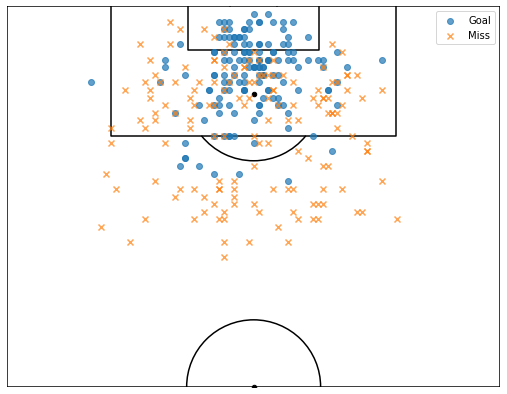

In [7]:
# for a real representation of the data, let's try different characteristics
#remember these are just for demonstration

idx = np.where((df['Goal']==1) & (df['Distance'] < 25)) 
df_log_goal = df.iloc[idx]
idx = np.where((df['Goal']==0) & (df['Distance']> 5)) 
df_log_miss = df.iloc[idx]


#same as before
prob=np.array(df['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
goals = plt.scatter(data = df_log_goal.head(150),x='Y', y='X',alpha=.7)
misses = plt.scatter(data = df_log_miss.head(150),x='Y', y='X',alpha=.7,marker='x')
classifer = Arc(xy=(10,10),width=12,height=12)
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.legend((goals,misses),('Goal','Miss'))
plt.axis('off')


plt.show()

In the event where the data is not cleanly separable, we must look to model the probability as opposed to assigning hard zero and ones. We have already seen in our data exploration that there are clear trends for the probability with respect to the distance and angle variables. What function should we adopt to model these trends?  There are numerous functions that map out probabilities and fit non-separable data, but we use the logistic function (also known as the sigmoid function) due to its simplicity.

$$
\begin{array}{rcl}
  G(y) & \equiv & \dfrac{1}{1 + e^{-y}} \equiv \dfrac{1}{1+e^{-(\alpha x_{1} +\beta)}}
\end{array}
$$

Similar to the heaviside function, the logistic function takes in our predictors (distance in this case), but instead outputs values between zero and one. 


The logistic function takes any value in the domain $(-\infty, +\infty)$ and produces a value in the range $(0, 1)$. Thus, given a value $y$, we can interpret $G(y)$ as a conditional probability that the shot results in a goal, $G(y) \equiv \mathrm{Pr}[\mbox{label is }1 \,|\, y]$.

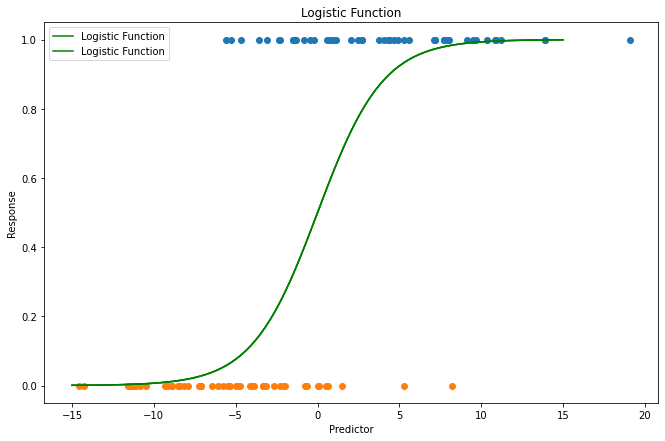

In [8]:
#plot a general logistic function for demonstration
fig, ax = plt.subplots(figsize=(11, 7))
rand_t=np.random.normal(5,5,50)
rand_f=np.random.normal(-5,5,50)
plt.scatter(rand_t,np.random.randint(1,2,50))
plt.scatter(rand_f,np.random.randint(0,1,50))

y = np.linspace(-15,15,100)
plt.plot(y,1/(1+np.exp(-(.5*y))),c='Green',label='')
plt.plot(y,1/(1+np.exp(-(.5*y))),c='Green',label='Logistic Function')
plt.plot(y,1/(1+np.exp(-(.5*y))),c='Green',label='Logistic Function')

plt.xlabel('Predictor')
plt.ylabel('Response')
plt.title('Logistic Function')
plt.legend()


The logistic function is an S-shaped curve that changes in slope and trajectory based on the values of the coefficients. Now the question is, how do we use the logistic function to model our shot data? Well, for each predictor variable we employ, we optimize the corresponding coefficient (α, β, etc.) to best fit the data.  What do we optimize on? Something known as the log-likelihood. The process of maximizing the log-likelihood is beyond the scope here, but if you are interested in the process, here is a good jumping off point. For a slower-paced visual demonstration, StatsQuest does a good job. 

# The xG model

Our goal is to create a model to accurately describe our existing data as well as possible, and to eventually predict future events. Before applying logistic regression to our entire dataset, we must split our data into training and test sets. The training set serves at the data we build our model on, and the testing set is the data we use to evaluate how well our model performs.  Fitting the training data to the logistic function will produce coefficients for our predictors ( I will do this by using the Scikit-learn library in Python). If we start by only fitting the distance variable, we should arrive at the optimal parameters to describe the training data:

In [9]:
#we are going to split the data into a test and train set(20% of it will go towards testing)
#for now we are going to model just the distance predictor
from sklearn import metrics 
from sklearn.model_selection import train_test_split
train_dis = df[['Goal','Distance']].copy()
x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), 
                                                    train_dis['Goal'], test_size=0.20, 
                                                    random_state=10)
from sklearn.linear_model import LogisticRegression
lgm_dis = LogisticRegression()
lgm_dis.fit(x_train_dis,y_train_dis)
log_odds = lgm_dis.coef_[0]
print(lgm_dis.coef_, lgm_dis.intercept_)
pd.DataFrame(log_odds, 
             x_train_dis.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

[[-0.14641592]] [0.09763449]


,coef
Distance,-0.146416


$$
\begin{array}{rcl}
  G(y) =  \dfrac{1}{1+e^{(0.146*distance - 0.097)}}
\end{array}
$$

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

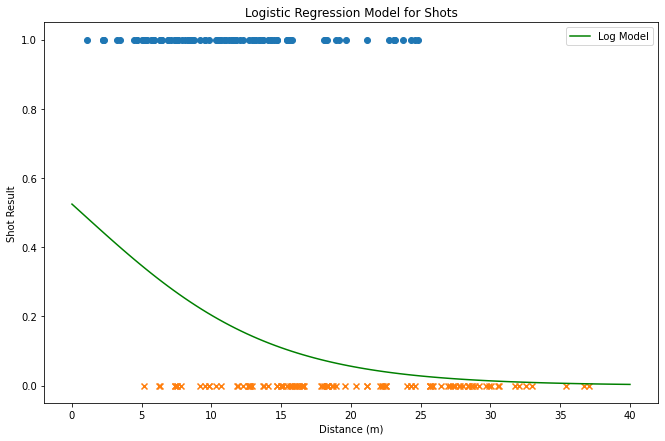

In [10]:
#compare this model to the sample data from before
df_HS_predictor = np.append(df_log_goal['Distance'].head(100), df_log_miss['Distance'].head(100))
df_HS_response = np.append(df_log_goal['Goal'].head(100), df_log_miss['Goal'].head(100))

fig, axes = plt.subplots(figsize=(11,7))
goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(0,40,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='Green',label='Log Model')

plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')


While the graph above produces some certification that our coefficients produce a reasonable fit, it is not very clear graphically how good this fit is, especially considering this is just a small sample of our training data. Instead of measuring the goodness of fit numerically, let’s examine another graphic. As we constructed in Part I, we can bin the data by distance, calculate the ratio of shots that resulted in a goal per bin, and then scatter plot the bins onto a graph. If we now superimpose the logistic model onto the scatter plot, we can see how well the function maps the data.

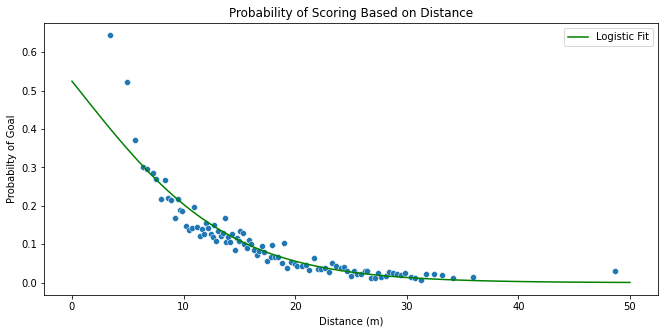

In [11]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value
df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df['Distance'],q=100)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob)
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
dis = np.linspace(0,50,100)
sns.lineplot(x = dis,y = 1/(1+np.exp((0.146*dis-.097))),color='green',legend='auto',label='Logistic Fit')


plt.show()

Remember that we did not fit our model to the points in figure 6 and 7, but rather to the 32,000 shots in our training set.  The purpose of these graphs is to gauge where our model performs well and where it does not. Plotting 32,000 points on a graph is not great for visualization, so we decide to plot a sample representation of the population. 

We can see from figure 7 that the model predicts the data well for values greater than 6 meters, yet it undervalues the probability of goals from closer distances. This is the sort of advantage a graphical approach will offer. We can try to better predict shots closer to goal by adding a quadratic term to the logistic function. That is, 

In [12]:
# we are going to have to use the pipe line function from sklearn to mesh a polynomial 
#function with logisitic regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
df_dis_2 = df[['Goal','Distance']].copy()
x_train_dis_2, x_test_dis_2, y_train_dis_2, y_test_dis_2 = train_test_split(df_dis_2.drop('Goal',axis=1), 
                                                    df_dis_2['Goal'], test_size=0.20, 
                                                    random_state=10)

poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lgm_dis_2 = LogisticRegression()
lgm_dis_2.fit(x_train_dis_2,y_train_dis_2)
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lgm_dis_2)])
pipe.fit(x_train_dis_2, y_train_dis_2)



print(lgm_dis_2.coef_,lgm_dis_2.intercept_)

[[-0.21632621  0.00206089]] [0.58419379]


$$
\begin{array}{rcl}
  G(y) =  \dfrac{1}{1+e^{(0.216*distance - 0.002*distance^2 - 0.584)}}
\end{array}
$$

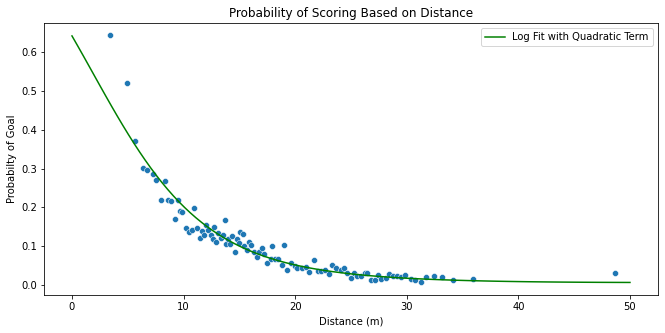

In [13]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value
df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df['Distance'],q=100)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob)
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
dis = np.linspace(0,50,100)
sns.lineplot(x = dis,y = 1/(1+np.exp((0.21632621*dis-0.00206089*dis**2-0.58419379))),color='green',
             label='Log Fit with Quadratic Term')



plt.show()

Now that is an improvement! If we add a quadratic term for the distance variable, we do a much better job at predicting shots close to goal. A numerical evaluation does not offer us this luxury. This sort of analysis is more of an art and less of a science, so it is important to play around with different options. Of course this is merely an ad hoc method of evaluating our model, for the purpose of graphically representing how the model compares to the data. We will explore a more concrete method of assessing the accuracy of the model soon, but let’s first add the angle predictor to the mix. We fit these two variables to the data and graph the probability via a contour map onto a pitch:



I am going to explore some different variables and polynomials. Some of them I have deleted or modified but if you are following along, try to play around with your own model. 

In [14]:
#similar to before but using ang variable
train_ang = df[['Goal','Angle Degrees']].copy()
x_train_ang, x_test_ang, y_train_ang, y_test_ang = train_test_split(train_ang.drop('Goal',axis=1), 
                                                    train_ang['Goal'], test_size=0.20, 
                                                    random_state=10)
from sklearn.linear_model import LogisticRegression
lgm_ang = LogisticRegression()
lgm_ang.fit(x_train_ang,y_train_ang)
log_odds_ang = lgm_ang.coef_[0]
print(lgm_ang.coef_, lgm_ang.intercept_)
pd.DataFrame(log_odds_ang, 
             x_train_ang.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

[[0.05221106]] [-3.60645775]


,coef
Angle Degrees,0.052211


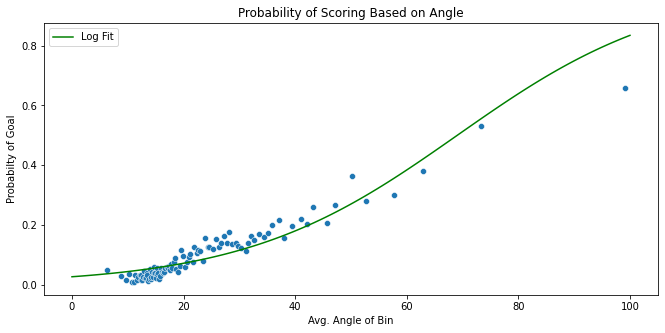

In [15]:
#same for the angle
fig, axes = plt.subplots(figsize=(11, 5))
df['Angle_Bins'] = pd.qcut(df['Angle Degrees'],q=100)
angle_prob = df.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob)
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")
ang = np.linspace(0,100,100)
sns.lineplot(x = ang,y = 1/(1+np.exp(-(lgm_ang.coef_[0][0]*ang+lgm_ang.intercept_[0]))),color='green',
             label='Log Fit')


plt.show()

In [16]:
df_poly_ang = df[['Goal','Angle Degrees']].copy()
X_train, X_test, Y_train, Y_test = train_test_split(df_poly_ang.drop('Goal',axis=1), 
                                                    df_poly_ang['Goal'], test_size=0.20, 
                                                    random_state=10)

poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lr_ang_poly = LogisticRegression()
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lr_ang_poly)])
pipe.fit(X_train, Y_train)

log_odds = lr_ang_poly.coef_[0]


print(lr_ang_poly.coef_,lr_ang_poly.intercept_)

[[ 0.08400573 -0.00035088]] [-4.14642689]


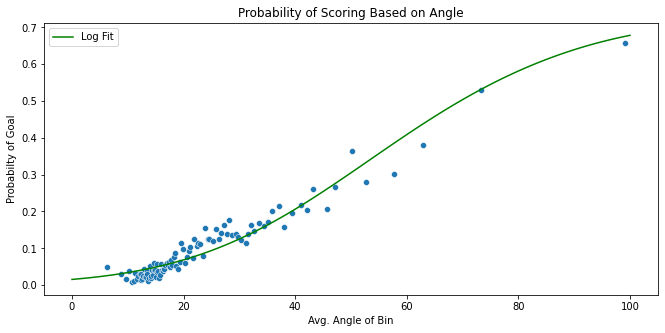

In [17]:
#same for the angle
fig, axes = plt.subplots(figsize=(11, 5))
df['Angle_Bins'] = pd.qcut(df['Angle Degrees'],q=100)
angle_prob = df.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob)
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")
ang = np.linspace(0,100,100)
sns.lineplot(x = ang,y = 1/(1+np.exp(-(lr_ang_poly.coef_[0][0]*ang + lr_ang_poly.coef_[0][1]*ang**2
                                       + lr_ang_poly.intercept_[0]))),color='green',
             label='Log Fit')


plt.show()

In [18]:
train_2 = df[['Goal','Distance','Angle Radians']].copy()
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(train_2.drop('Goal',axis=1), 
                                                    train_2['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_2 = LogisticRegression(random_state=0)
lgm_2.fit(x_train_2,y_train_2)
log_odds = lgm_2.coef_[0]
print(lgm_2.coef_, lgm_2.intercept_)
print(pd.DataFrame(log_odds, 
             x_train_2.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False))


[[-0.08801449  1.41598327]] [-1.48107418]
                   coef
Angle Radians  1.415983
Distance      -0.088014


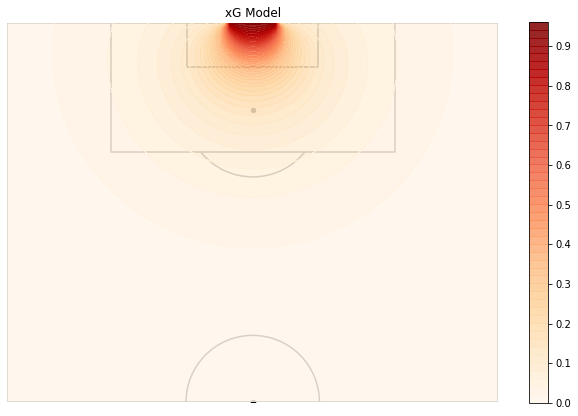

In [19]:
def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
h_grid = Logistic(lgm_2.coef_[0][1]*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  +lgm_2.coef_[0][0]*np.sqrt((x1_grid)**2+(x0_grid)**2)+lgm_2.intercept_[0])


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contourf(x_0,x1, h_grid,alpha=.85,cmap='OrRd',levels=50)


plt.title('xG Model')

#plt.axis('off')
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()


This represents the simplest expected goals model. If we flip back to part one and compare the two dimensional density plot with the xG model, we see that our two parameter model matches the probability distribution to a reasonable extent. Now for a closer look at the contour plot:

(22.0, 0.0)

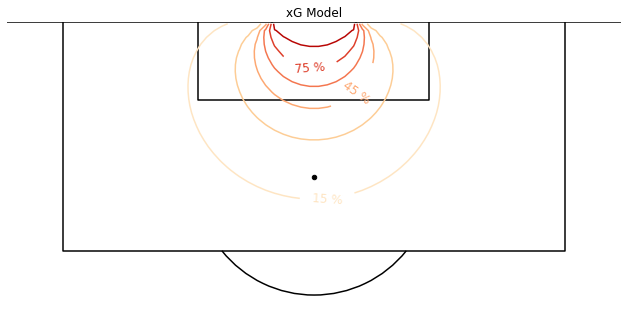

In [20]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
h_grid = Logistic(1.57148079*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  -0.11023242*np.sqrt((x1_grid)**2+(x0_grid)**2)-1.02645936)


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contour(x_0,x1, h_grid,alpha=1,cmap='OrRd',levels=7)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
plt.clabel(CS, CS.levels[1::2],inline=True, fmt=fmt, fontsize=12)

plt.title('xG Model')

#plt.axis('off')
ax.set_xlim(10,58)
ax.set_ylim(22,0)



This is where we need to invoke some footballing knowledge. While the probability of values in central positions resembles the density plot from Part I, they are far too large for small angle positions near the goal line.  Is it at all plausible to score from 5 meters out and effectively zero angle with the goal? Never mind having a 15% chance! This is a clear flaw with this simplified model. This does however represent a chance to experiment with different possibilities and variables. We can choose to add polynomial terms and interaction terms (such as δ*distance*angle) or add another variable all together. I tried a number of options and found that adding a “distance to center” of the pitch variable to produce the most reasonable contour plot: 

In [21]:
#playing around with polynomials and variables to try to get better values for small angs
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
df_3 = df[['Goal','Distance','Angle Radians','Y']].copy()
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_3.drop('Goal',axis=1), 
                                                    df_3['Goal'], test_size=0.20, 
                                                    random_state=10)
#ct = ColumnTransformer([('poly_X0X1', PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False), 
#                         ['Distance','Angle Radians']),
#                         ('poly_x0**2', FunctionTransformer(func=lambda x: x**2), ['Distance']),
#                         ('Y',FunctionTransformer(func=lambda x: x),['Y'])])

#poly_train = ct.fit_transform(X_train)
#poly_test = ct.fit_transform(X_test)


lgm_3 = LogisticRegression()

lgm_3.fit(x_train_3, y_train_3)
#print('dis, ang, Y')
print(lgm_3.coef_,lgm_3.intercept_)


[[-0.08812064  1.41583297 -0.00209564]] [-1.40900091]


(27.0, 0.0)

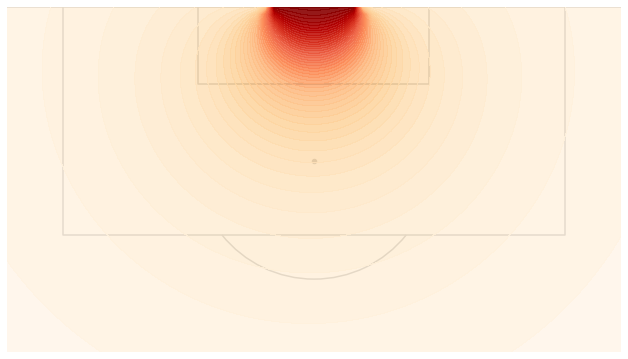

In [22]:
def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)

x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
ang = np.arccos((c**2-a**2-b**2)/(-2*a*b))
dis = np.sqrt((x1_grid)**2+(x0_grid)**2)
#h_grid_poly = Logistic(lr.coef_[0][0]*dis +lr.coef_[0][1]*ang + lr.coef_[0][2]*dis*ang +
#                       lr.coef_[0][3]*(ang**2)+lr.coef_[0][3]*x0_grid+lr.intercept_[0])

h_grid_Y = Logistic(lgm_3.coef_[0][0]*dis +lgm_3.coef_[0][1]*ang +lgm_3.coef_[0][2]*(x0_grid) +lgm_3.intercept_[0])



fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contourf(x_0,x1, h_grid_Y,alpha=.9,cmap='OrRd',levels=50)


#plt.title('xG Model')

plt.axis('off')

ax.set_xlim(10,58)
ax.set_ylim(27,0)
#ax.set_xlim(0,68)
#ax.set_ylim(53,0)
#plt.colorbar()


(22.0, 0.0)

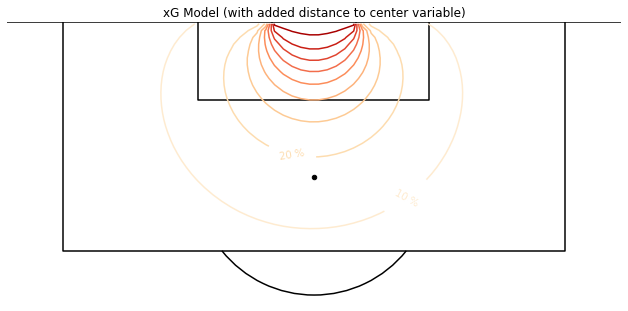

In [23]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)



CS =plt.contour(x_0,x1, h_grid_Y,alpha=1,cmap='OrRd',levels=10)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
plt.clabel(CS, CS.levels[:3],inline=True, fmt=fmt, fontsize=10)

plt.title('xG Model (with added distance to center variable)')

plt.axis('off')
ax.set_xlim(10,58)
ax.set_ylim(22,0)

Adding this new variable decreases the chance of scoring from small angles close to goal, but does little for further distances. This is probably because there are few shots taken from those positions and of the shots recorded, some might be miss-hit crosses that resulted in unlikely goals. Players rarely take shots from these wide, low angle positions. If we had 10 seasons worth of data, we would see the model begin to undervalue those types of shots. We could also choose to add artificial data in the form of misses on the goal line to fix this flaw, but for now we choose to live with it.  Remember that while I have tried to add polynomial factors and this new variable to fix this flaw, the optimization in logistic regression will still fit the training data best it can. That is, as much as I want to tell the model to undervalue these types of shots, logistic regression only knows how to maximize the likelihood. I can merely add more flexibility to the model but I cannot tell it how and where to curve. 

While we have visualized these models, we still do not have anything concrete on how well they perform at predicting future data. If we also want to add more variables, such as a categorical header variable, the visualization is going to become more cumbersome and difficult. For that we are going to need to employ some statistical analysis.



# Model Evaluation

If we want to assess the accuracy of our model, we have to test how well it can predict future events. But this raises another concern. How do we classify a shot with our new expected goals model? Unlike the Heaviside function, which gives hard classifications, the logistic regression model returns a probability of a shot resulting in a goal.

 In order to make a classification, we have to define a threshold. This threshold essentially splits the logistic function, assigning goals for where the model lies above the threshold and misses below. For example:

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

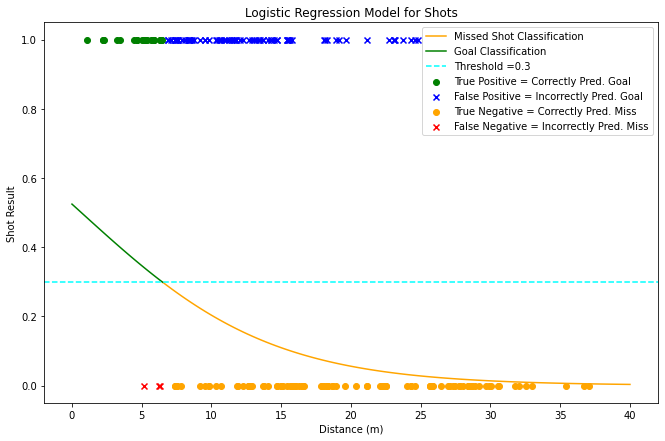

In [24]:
#plot the heaviside function on top of the responses for the seperable data above
threshold=0.3
threshold_x=6.5
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')


With a threshold of 0.3, the logistic model produces four possible classifications, which can be summarized in a confusion matrix.  

[[7022  186]
 [ 711  173]]


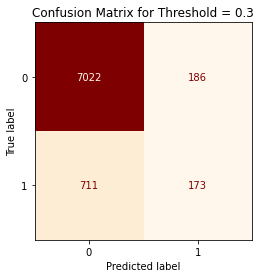

In [25]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
threshold=[0.3]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_3 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_3).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.3')
print(cm_dis_3)

From the confusion matrix, we can gather for which classifications the model gives promising predictions and for which it does not. For the example above, the model does a fantastic job of predicting misses but a poor job of predicting goals, and this is understandable if we examine where the threshold intersects the model. We can define the  model’s ability to correctly predict goals with a metric known as sensitivity and the model’s ability to correctly predict a miss is given by the specificity. 


$$
\begin{array}{rcl}
  Sensitivity =  \dfrac{True Positives}{True Positives + False Negatives}
\end{array}
$$

$$
\begin{array}{rcl}
  Specificity =  \dfrac{True Negatives}{False Positives + True Negatives}
\end{array}
$$


For the threshold value that we examined above, the model would produce the following confusion matrix on the entire testing data:

In [26]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_3 = cm_dis_3[1][1]/(cm_dis_3[1][1]+cm_dis_3[1][0])
print('sensitivity = ' + str(sensitivity_3))
#the ability of the model to correctly identify shots that did not result in a goal
specificity_3 = cm_dis_3[0][0]/(cm_dis_3[0][1]+cm_dis_3[0][0])
print('specificity = '+ str(specificity_3) )

sensitivity = 0.19570135746606335
specificity = 0.9741953385127636


Text(0.5, 1.0, 'Logistic Regression Model for Shots')

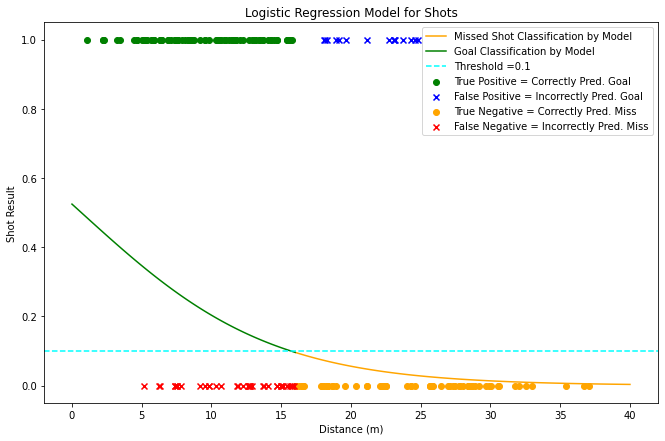

In [27]:
threshold=0.1
threshold_x=16
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification by Model')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification by Model')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')



[[4400 2808]
 [ 196  688]]


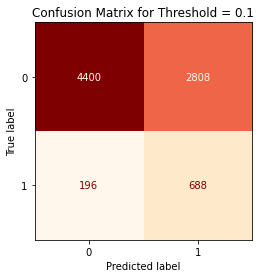

In [28]:
threshold=[0.1]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_10 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_10).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.1')
print(cm_dis_10)

In [29]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_10 = cm_dis_10[1][1]/(cm_dis_10[1][1]+cm_dis_10[1][0])
print('sensitivity = ' + str(sensitivity_10))
#the ability of the model to correctly identify shots that did not result in a goal
specificity_10 = cm_dis_10[0][0]/(cm_dis_10[0][0]+cm_dis_10[0][1])
print('specificity = '+ str(specificity_10) )
print(cm_dis_10[0][1])

sensitivity = 0.7782805429864253
specificity = 0.6104328523862376
2808


Now we have the opposite effect. The logistic regression model produces a better classification of goals but misclassifies misses at a much high volume. If we split the difference and choose a threshold in between the previous two:

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

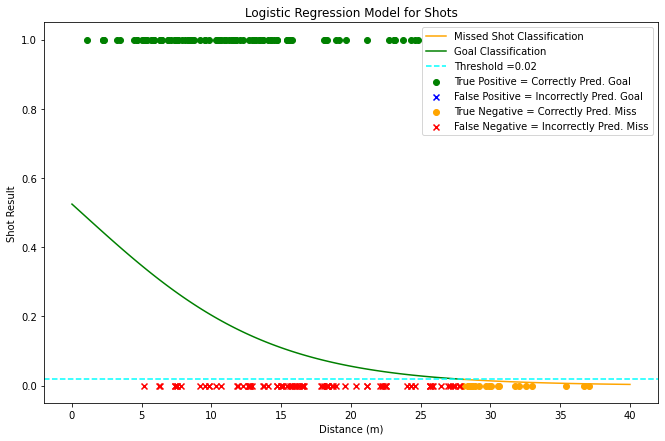

In [30]:

threshold=0.02
threshold_x=28
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')




[[1372 5836]
 [  29  855]]


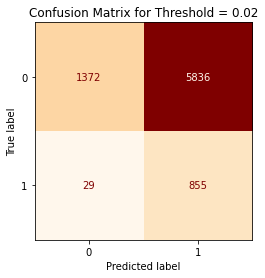

In [31]:
threshold=[0.02]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_02 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_02).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.02')
print(cm_dis_02)

In [32]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_02 = cm_dis_02[1][1]/(cm_dis_02[1][1]+cm_dis_02[1][0])
print('sensitivity = ' + str(sensitivity_02))
#the ability of the model to correctly identify shots that did not result in a goal
specificity_02 = cm_dis_02[0][0]/(cm_dis_02[0][0]+cm_dis_02[0][1])
print('specificity = '+ str(specificity_02) )
print(cm_dis_02[0][1])

sensitivity = 0.9671945701357466
specificity = 0.19034406215316316
5836


We now predict goals and misses at a more balanced rate. We have seen that three different thresholds produce vastly different predictions from our model. Where they vary is in their specificity and sensitivity; that is, their ability to correctly predict goals and misses. It’s a tradeoff. So, what threshold do we choose? Well, neither of them and all of them.  

Let’s take a step back. If we were using a logistic regression model to identify if a patient has cancer, then we would adopt a high threshold, to forgo a high specificity rate in favor of high sensitivity. We would much rather give out false positive results rather than false negatives. We do not want someone to walk away thinking they passed a cancer screening when in fact they have cancer. When we are trying to model goal probability, we do not have such a preference. In fact, trying to predict goals outright is not all that useful to begin with. As we will see in the next part, the power of the expected goal model does not lie in making a prediction for a single shot. So what was the purpose of investigating thresholds and confusion matrices? We can use them to compare different models using something known as a Receiver Operator Characteristic (ROC) graph.

Text(0.5, 1.0, 'ROC Graph')

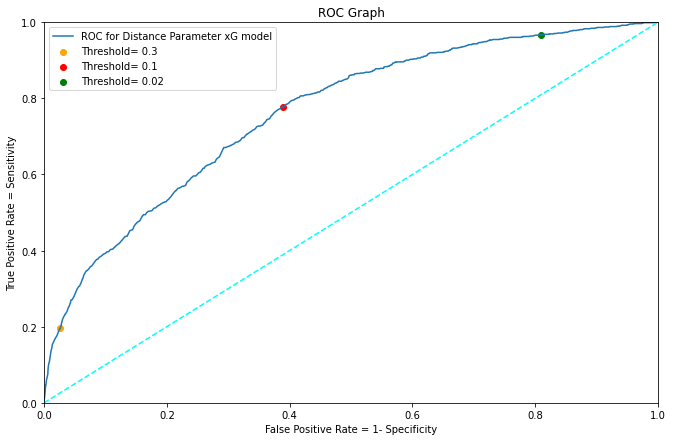

In [33]:
from sklearn.metrics import roc_curve
fig, axes = plt.subplots(figsize=(11,7))
y_score = lgm_dis.decision_function(x_test_dis)
fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
plt.plot(fpr,tpr,label='ROC for Distance Parameter xG model')

plt.scatter(1-specificity_3,sensitivity_3,c='orange',label='Threshold= 0.3')
plt.scatter(1-specificity_10,sensitivity_10,c='red',label='Threshold= 0.1')
plt.scatter(1-specificity_02,sensitivity_02,c='green',label='Threshold= 0.02')
y_45 = np.linspace(0,1,100) 
plt.plot(y_45,y_45,linestyle='dashed',c='cyan')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate = 1- Specificity')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Graph')


Using a small step size, the ROC curve plots the model’s ability to predict goals correctly versus its ability to incorrectly predict misses for different threshold values. As you move up the y-axis, the model better predicts goals, and as we move to the left along the x-axis, the model better predicts misses. It essentially maps the trade-off between predicting goals and predicting misses. The dashed line represents a model that has no predictive power and is essentially useless because for every correct classification, it also predicts an incorrect classification. Therefore, the further away our ROC curve is from the 45 degree line, the better overall job it does at classifying the test data. Another way of looking at it is that the larger the area under the curve, the better our model is in describing the test data.  This is useful to us because we can use it to compare different models and see if there is any substantial advantage to adding more variables to our model.

In [34]:
train_3 = df[['Goal','Distance','Angle Radians','Y']].copy()
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(train_3.drop('Goal',axis=1), 
                                                    train_3['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_3 = LogisticRegression()
lgm_3.fit(x_train_3,y_train_3)
log_odds = lgm_3.coef_[0]
print(lgm_3.coef_, lgm_3.intercept_)


train_4 = df[['Goal','Distance','Angle Radians','header']].copy()
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(train_4.drop('Goal',axis=1), 
                                                    train_4['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_4 = LogisticRegression()
lgm_4.fit(x_train_4,y_train_4)
log_odds = lgm_4.coef_[0]
print(lgm_4.coef_, lgm_4.intercept_)

[[-0.08812064  1.41583297 -0.00209564]] [-1.40900091]
[[-0.10757759  1.59478695 -1.01155408]] [-1.07169239]


Text(0.5, 1.0, 'ROC Graph')

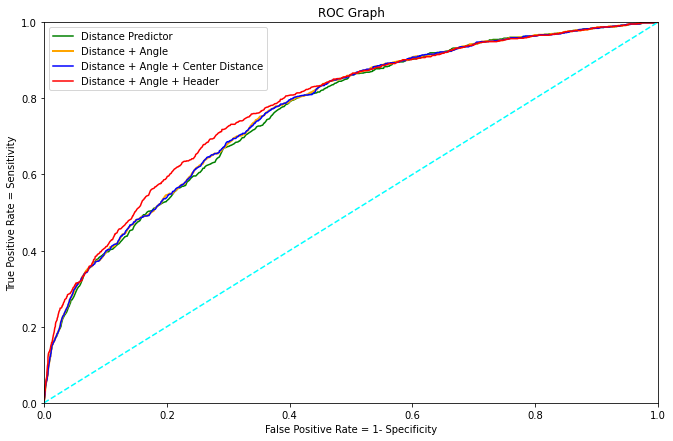

In [35]:
fig, axes = plt.subplots(figsize=(11,7))


y_score = lgm_dis.decision_function(x_test_dis)
fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
plt.plot(fpr,tpr,label='Distance Predictor',c='green')

y_score_2 = lgm_2.decision_function(x_test_2)
fpr2, tpr2, _  = roc_curve(y_test_2,y_score_2, pos_label=lgm_2.classes_[1])
plt.plot(fpr2,tpr2,label='Distance + Angle',c='orange',linewidth=2)

y_score_3 = lgm_3.decision_function(x_test_3)
fpr_3, tpr_3, _  = roc_curve(y_test_3,y_score_3, pos_label=lgm_3.classes_[1])
plt.plot(fpr_3,tpr_3,label='Distance + Angle + Center Distance',c='blue')

y_score_4 = lgm_4.decision_function(x_test_4)
fpr_4, tpr_4, _  = roc_curve(y_test_4,y_score_4, pos_label=lgm_4.classes_[1])
plt.plot(fpr_4,tpr_4,label='Distance + Angle + Header',c='red')
plt.legend()

#y_score_5 = lgm_5.decision_function(poly_test)
#fpr_5, tpr_5, _  = roc_curve(y_test_5,y_score_5, pos_label=lgm_5.classes_[1])
#plt.plot(fpr_4,tpr_4,label='Distance + Angle + Header',c='yellow')
#plt.legend()

y_45 = np.linspace(0,1,100) 
plt.plot(y_45,y_45,linestyle='dashed',c='cyan')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate = 1- Specificity')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Graph')

Now we have something concrete when assessing our model. If we look closely, a model with distance and angle as input variables produces the same area under the curve (AUC) as the same model but with an added “distance to center” parameter. So, contrary to some of the assumptions we made earlier, the “distance to center”predictor does not add much to the performance of our model and we should exclude it. While the “distance to center” parameter showed a slight change to the model in areas close to the goal line, this change meant very little as so few shots are taken from those positions. The AUC therefore tells us that adding the center to distance variable is rather useless. Note that we could have just as easily used p-values to learn if the center to distance parameter is useful towards our model. 

Another advantage of the ROC curve is if we chose to use other classification techniques, such as SVM, random forests, neural networks, etc, we could compare and contrast the performance of those model to the one we created here. I think this is overkill for the problem at hand, but is an avenue for further exploration. While these alternative models would produce similar results, logistic regression provides us with a fairly simple and digestible method to describe shot results, whereas these other methods require a deeper and more sophisticated understanding of machine learning techniques. 

 

In [39]:
train_5 = df[['Goal','Distance','Angle Radians','header']].copy()
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(train_5.drop('Goal',axis=1), 
                                                    train_5['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_5 = LogisticRegression(fit_intercept=False, solver='lbfgs')
lgm_5.fit(x_train_5,y_train_5)


X = x_train_4
from numpy.random import binomial, normal
from scipy.stats import bernoulli, binom
np.random.seed(37)

def full_log_likelihood(w, X, y):
    score = np.dot(X, w).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def null_log_likelihood(w, X, y):
    z = np.array([w if i == 0 else 0.0 for i, w in enumerate(w.reshape(1, X.shape[1])[0])]).reshape(X.shape[1], 1)
    score = np.dot(X, z).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)


w = np.array(lgm_4.coef_).transpose()
y_pred = lgm_5.predict_proba(X)[:, 1]

n = 32366
z = np.dot(X, np.array([1.0, 2.0, 3.0])) + normal(0.0, 1.0, n)
p = 1.0 / (1.0 + np.exp(-z))
y = binom.rvs(1, p)


def mcfadden_rsquare(w, X, y):
    return 1.0 - (full_log_likelihood(w, X, y) / null_log_likelihood(w, X, y))

def mcfadden_adjusted_rsquare(w, X, y):
    k = float(X.shape[1])
    return 1.0 - ((full_log_likelihood(w, X, y) - k) / null_log_likelihood(w, X, y))
 
print(mcfadden_adjusted_rsquare(w,X,y))


0.1714345578023222


Before we close, I want to briefly touch on R-squared values. In linear regression, R-squared measures the percentage of the response variable variation that a linear model explains. An R-squared of zero means the model does not explain any of the variation in the response and an R-squared of one represents a model that perfectly describes the data. R-squared does not directly translate to classification and logistic regression, but there are a number of pseudo R-squared values that mimic the linear regression version. The most popular, and the one I have employed, is Mcfadden’s R-squared, which measures the log likelihood of a null model (essentially just an intercept value) versus our model. We can interpret it in a similar fashion to the analogous linear regression R-squared.  Values approaching one represent a model that perfectly classifies the data (such as the example we used to introduce the Heaviside function). For our best model based on the AUC (using distance, angle and header variables), Mcfadden’s R-squared comes out to about 0.171. Now before you throw out the xG model, we must understand that there is no definite answer to what value represents a good model and what represents a bad model. Goals, as we have discussed earlier, are mostly random. We need to remember that every shot is unique, comprised of hundreds of different variables that we have tried to model using just three. For that we should not expect to predict goals with certainty or anywhere near it. Some of this is due to our inability to model all these variables. Consider that while distance and angle give us a good sense of the likelihood of shot resulting in a goal, we did not take into account where the goalkeeper is positioned, if the shot was taken with a weak foot or strong foot, shot height at point of contact, the game state, home field advantage, if there are many bodies between the goal and the shot, etc. These are just a handful of the quantifiable variables that have an influence. There are also variables that are not easily quantifiable: what is the state of the pitch (as in rugged or is it a carpet), is fatigue playing a role, morale and confidence, and other soft factors. Even after neglecting these other variables, there is also some level of intrinsic randomness to shots. We have tried to model a very complex situation with a simple 3 parameter model; we should not expect such a high R-squared value. Nonetheless, xG is far from useless and in fact has been revolutionary to the way we approach the game. 

In the next and final part, we will explore applications of the expected goals model, its strengths, weaknesses, the dangers of extrapolation and hopefully prove that expected goals are worthwhile. Until then. 